In [1]:
import sys
import pandas as pd
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

sys.path.append('../src/utils')
from utils import load_data
from modeling_dev import (
    split_data, 
    scale_data, 
    train_and_plot_model,
    evaluate_model_reg, 
    train_random_forest_rscv, 
    train_gradient_boosting_rscv, 
    train_extra_trees_rscv, 
    train_and_evaluate_stacking
)

In [2]:
# Cargar los datos
df = load_data('../data/processed/prediction_edad_marcha.csv')
cols = ['edad', 'step length_walk','total force rate_walk','footstrike type_walk','stance excursion (mp->to)_walk','imc']

# Dividir en train y test
X_train, X_test, y_train, y_test = split_data(df[cols], 'edad')
(X_train_ss, X_test_ss), (X_train_mm, X_test_mm) = scale_data(X_train, X_test)

In [3]:
rf_model = train_random_forest_rscv(X_train, y_train)
print("Train: ",rf_model.score(X_train,y_train))
print("Test: ",rf_model.score(X_test,y_test))

Train:  0.8043107345048037
Test:  0.5042486349492415


In [4]:
gbr_model = train_gradient_boosting_rscv(X_train, y_train)
print("Train: ",gbr_model.score(X_train,y_train))
print("Test: ",gbr_model.score(X_test,y_test))

Train:  0.8320173040018191
Test:  0.4554384844102758


In [5]:
et_model = train_extra_trees_rscv(X_train, y_train)
print("Train: ",et_model.score(X_train,y_train))
print("Test: ",et_model.score(X_test,y_test))

Train:  0.825621188731737
Test:  0.5199700682476415


MAE: 7.4110
MSE: 87.6450
RMSE: 9.3620
R2: 0.5040


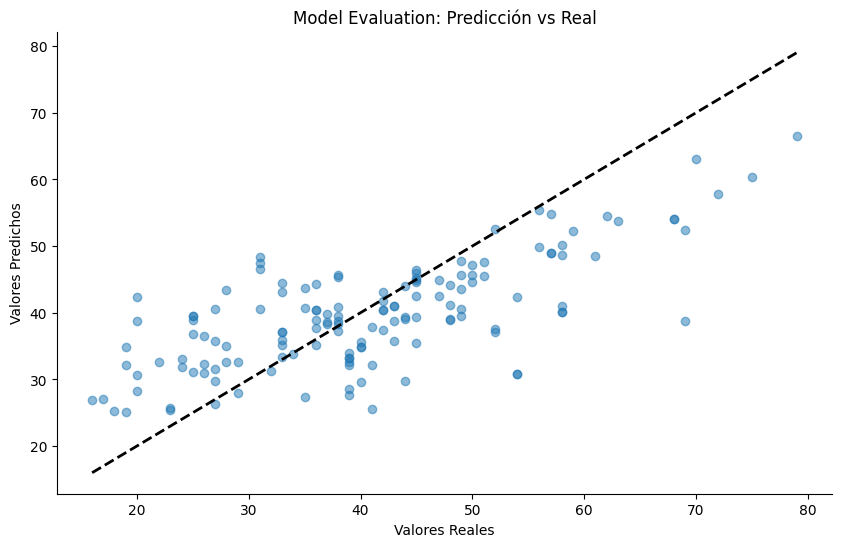

{'MAE': 7.411, 'MSE': 87.645, 'RMSE': 9.362, 'R2': 0.504}

In [6]:
evaluate_model_reg(rf_model, X_test, y_test)

MAE: 7.6190
MSE: 96.2740
RMSE: 9.8120
R2: 0.4550


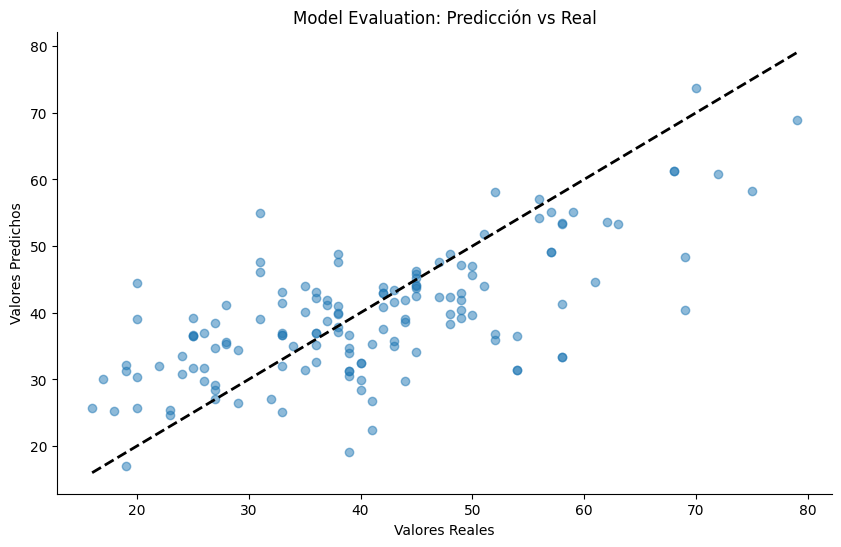

{'MAE': 7.619, 'MSE': 96.274, 'RMSE': 9.812, 'R2': 0.455}

In [7]:
evaluate_model_reg(gbr_model, X_test, y_test)

MAE: 7.4190
MSE: 84.8650
RMSE: 9.2120
R2: 0.5200


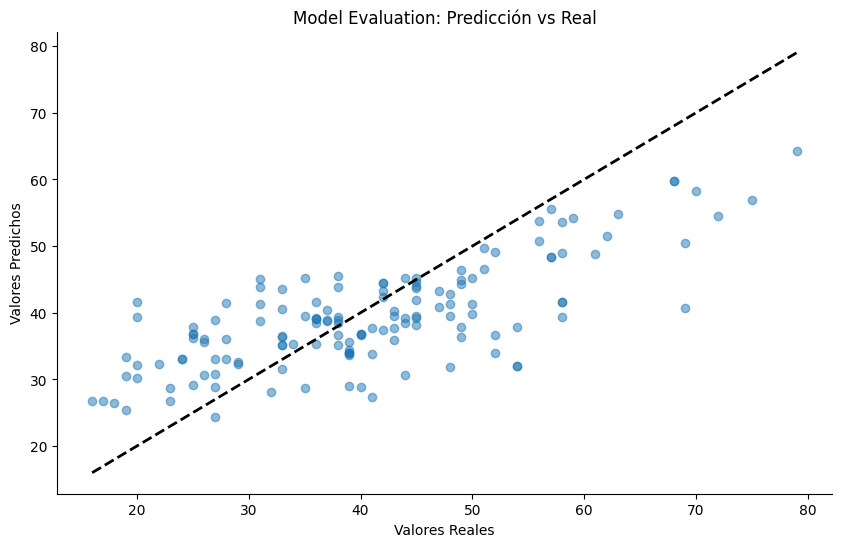

{'MAE': 7.419, 'MSE': 84.865, 'RMSE': 9.212, 'R2': 0.52}

In [8]:
evaluate_model_reg(et_model, X_test, y_test)

In [9]:
# Definir la lista de final_estimators a probar
final_estimators = [
    ('Linear Regression', LinearRegression()),
    ('Ridge', Ridge()),
    ('ElasticNet', ElasticNet()),
    ('Decision Tree', DecisionTreeRegressor(max_depth=5)),
    ('Gradient Boosting', GradientBoostingRegressor(n_estimators=100))
]

# Modelos base para el stacking
base_estimators = [
        ('rf', rf_model),
        ('gbr', gbr_model),
        ('et', et_model)
]

# Iterar sobre cada final_estimator
for name, estimator in final_estimators:
    print(f"Testing with final estimator: {name}")
    train_and_evaluate_stacking(X_train, y_train, X_test, y_test, base_estimators, estimator, name=name)
    print("="*50)

Testing with final estimator: Linear Regression
Linear Regression - Train R2: 0.8659, Test R2: 0.5221
Testing with final estimator: Ridge
Ridge - Train R2: 0.8659, Test R2: 0.5221
Testing with final estimator: ElasticNet
ElasticNet - Train R2: 0.8635, Test R2: 0.5203
Testing with final estimator: Decision Tree
Decision Tree - Train R2: 0.7691, Test R2: 0.4390
Testing with final estimator: Gradient Boosting
Gradient Boosting - Train R2: 0.8248, Test R2: 0.4510


## Conclusiones

En la exploración de modelos para predecir la edad basada en parámetros biomecánicos y antropométricos, se han seleccionado tres modelos principales por su rendimiento individual: **RandomForest, GradientBoosting, y ExtraTrees**. Estos modelos, al evaluarlos de forma independiente, muestran resultados mixtos en cuanto a la relación entre sobreajuste y capacidad predictiva en el conjunto de prueba:

- **RandomForest** mostró un equilibrio razonable entre entrenamiento y prueba, con un R2 de **0.8043** en entrenamiento y **0.5042** en prueba, lo que sugiere un ajuste moderado sin llegar a un sobreajuste severo.
- **GradientBoosting** también presentó un ajuste razonable con un R2 de **0.8320** en entrenamiento frente a un **0.4554** en prueba, aunque con un descenso notable en el rendimiento en el conjunto de prueba que podría indicar un inicio de sobreajuste.
- **ExtraTrees** ofreció un equilibrio similar, con un R2 de **0.8256** en entrenamiento y un R2 de **0.5200** en prueba, siendo este el que menos caída mostró en la eficacia entre el entrenamiento y la prueba.

Posteriormente, estos modelos se utilizaron como estimadores base en un `StackingRegressor`, evaluando diferentes `final_estimators` para mejorar la generalización. Los resultados variaron ligeramente con distintos estimadores finales, donde los modelos lineales como la **Regresión Lineal y Ridge** demostraron ser los más efectivos, alcanzando un R2 en prueba de aproximadamente **0.5221**, sugiriendo que estos métodos lineales ayudan a estabilizar las predicciones cuando se combinan con estimadores base más complejos.

Estos resultados enfatizan la importancia de una selección cuidadosa tanto de los modelos base como del estimador final en técnicas de ensamblaje para lograr un balance adecuado entre precisión y generalización. Las pruebas con `ElasticNet`, `Decision Tree` y `Gradient Boosting` como final_estimators mostraron una reducción en la efectividad, especialmente con modelos más simples o altamente regularizados que no armonizaron tan bien con los modelos base en términos de capturar la complejidad del problema.

La **estrategia de ensamblaje** se destaca como un enfoque robusto para mejorar la precisión predictiva en tareas complejas como la estimación de la edad a partir de parámetros biomecánicos, donde la elección de un modelo bien calibrado para el estimador final es crucial para optimizar la generalización y evitar el sobreajuste. Los próximos pasos deberían enfocarse en una optimización más refinada de los hiperparámetros y una posible expansión de la ingeniería de características para maximizar el rendimiento del modelo final.